In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import random

import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
import gala.coordinates as gc

import astropy.coordinates as coord
import astropy.units as u
from astropy.table import QTable, Table
from astropy.coordinates import Galactocentric, ICRS, SkyCoord, Distance, CartesianRepresentation, SphericalRepresentation


In [2]:
coord.galactocentric_frame_defaults.set('v4.0')

<ScienceState galactocentric_frame_defaults: {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg...>

In [3]:
# Parameters of the SAGA host and it's satellite
# host

Mh = 10**11.81  # Halo mass of the host
MHI = 0.91e9
M_star = 5.9e10 # stellar mass from Rubin82, at R_25
RAH, DecH = 149.5878735, 32.3698905
dist = 25.00516842*u.Mpc  # mpc

# satellite

m_star = 10**7.17
m_gas_sf = 10**7.74
m_gas_que = 10**6.74
Dh = 75  # kpc
RAs, Decs = 149.6921195816266, 32.51841252708709
PA = 3.68 * u.rad # position angle from the plane of the Host
v_sat = 65.95 # km/s LOS satellite velocity
print(PA)

3.68 rad


In [4]:
### satellite luminosity
Mr_sat = -13.1538315
Mr_sol = 4.76
Lsat = 10**(0.4 * (Mr_sol-Mr_sat)) #In Lsol
print(np.log10(Lsat))

7.165532600000001


In [5]:
#coordinates on the skY of the host, satellilte and QSO

cooH = SkyCoord(RAH*u.deg, DecH*u.deg, distance=dist)
cooSat = SkyCoord(RAs*u.deg, Decs*u.deg, distance=dist)

cooQ1 = SkyCoord(149.0967254638672*u.deg, 32.60601806640625*u.deg, distance = dist) #distance is different but for the on sky projection is wnough toassume is the same as host
cooQ2 = SkyCoord(149.58726501464844*u.deg, 32.4006233215332*u.deg, distance=dist)
cooQ3 = SkyCoord(149.81187438964844*u.deg, 32.06591033935547*u.deg, distance=dist)

#distances on the sky between objects
distX = cooH.cartesian.x - cooSat.cartesian.x
distY=cooH.cartesian.y - cooSat.cartesian.y
distZ=cooH.cartesian.z - cooSat.cartesian.z

Dq1 = [cooH.cartesian.y - cooQ1.cartesian.y, cooH.cartesian.z - cooQ1.cartesian.z]
Dq2 = [cooH.cartesian.y - cooQ2.cartesian.y, cooH.cartesian.z - cooQ2.cartesian.z]
Dq3 = [cooH.cartesian.y - cooQ3.cartesian.y, cooH.cartesian.z - cooQ3.cartesian.z]

In [6]:
# coordinates frame - galactic
galcen_frame = coord.Galactocentric()


In [7]:
# central potential
potential = gp.MilkyWayPotential()


## 3D velocity assumptions

In [8]:
# we assume that the LOS velocity is all tangential

v_t = v_sat  # measured


In [9]:
def get_3D_cart_vel(vt, vr, pa, ra_or_dec = 'ra'):
    
    # Create the array of possible velocity pairs for orbit integration
    
    # algnement of Vt vector
    if ra_or_dec == 'ra' or  ra_or_dec == 'RA' or  ra_or_dec == 'Ra':
        
        # Vt along RA
        vx = 0
        vy = v_sat + vr * np.cos(PA)
        vz = vr * np.sin(PA)
        
    elif ra_or_dec == 'dec' or  ra_or_dec == 'Dec' or  ra_or_dec == 'DEC':
        
        # Vt alnong DEC
        vx = 0
        vy = vr * np.cos(PA)
        vz = v_sat + vr * np.sin(PA)
        
    v = np.array([vx,vy,vz])
    
    return v

## 3D position 

In [10]:
# 3D cartesian position

dy,dz = distY.to(u.kpc),distZ.to(u.kpc)

x = 0
y = dz.value
z = dy.value

print(x,y,z)

0 -54.701153836628436 50.704683218839364


## Defining galactocentric frame (as in the SAGA host - centric)

In [11]:
# define galactocentric coordinates
RAH, DecH = 149.5878735, 32.3698905
host = SkyCoord(RAH*u.deg, DecH*u.deg, frame='icrs', representation_type='spherical')

print(host)

#center on the host
dist = (25.00516842*u.Mpc).to(u.kpc)  # mpc
hostd = host.realize_frame(SphericalRepresentation(lon=host.data.lon, lat=host.data.lat, distance=dist))
host_centric = Galactocentric(galcen_coord = hostd, galcen_distance=dist, z_sun=0, roll=-50*u.deg)  # roll is guessed to fit the sateliite position

print(host_centric)

#shift to ICRS -  to reproduce on-sky orbit
center_of_earth = SkyCoord(CartesianRepresentation(x=0*u.km, y=0*u.km, z=0*u.km), frame='gcrs')
center_of_earth.transform_to(host_centric).spherical.distance.to(u.kpc)
                                                                 
# represent satellite in a new frame
sat = SkyCoord(149.6921195816266*u.deg, 32.51841252708709*u.deg,frame='icrs', representation_type='spherical')
satd = sat.realize_frame(SphericalRepresentation(lon=sat.data.lon, lat=sat.data.lat,distance=dist))

<SkyCoord (ICRS): (ra, dec) in deg
    (149.5878735, 32.3698905)>
<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (149.5878735, 32.3698905, 25005.16842)>, galcen_distance=25005.16842 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=0.0 pc, roll=-50.0 deg)>


# Orbit integration

In [12]:
# As of now (Feb 2023) we have two options of tangential velocity vector - all towards RA and all towards Dec

In [13]:
# choose number of time steps
N = 5000
time_step = -0.05*u.Mpc # time step size

In [14]:
print(time_step)

-0.05 Mpc


In [15]:
# range of probed parameters: LOS distance and radial velocity
Vr = np.linspace(-500,500,100)  # radial velocity 
X = np.linspace(-300,300,100)  # LOS distance between satellite and host


In [16]:
# Table for the results
L = Table(names=("x [kpc]", "RV","Vt RA", "Q1_t1 [Myr]", "Q2_t1","Q3_t1", "Vt Dec", "Q1_t2", "Q2_t2","Q3_t2" ))


In [17]:
# run the orbits

V_bound_ra, V_bound_dec = [], []  # save the radial velocity of the bound system
ecc=np.array([])
for x in X:
    
    for vr in Vr:
        
        # 1) Vt -> RA
        
        vel_1 = get_3D_cart_vel(v_sat, vr,PA)
        w0_1 = gd.PhaseSpacePosition(pos=[x,y,z]*u.kpc,vel=vel_1*u.km/u.s)
        orbit1 = potential.integrate_orbit(w0_1, dt=time_step, n_steps=N)
        U1 = orbit1.potential_energy()

        # 2) Vt -> Dec

#         vel_2 = get_3D_cart_vel(v_sat, vr,PA, ra_or_dec='dec')
#         w0_2 = gd.PhaseSpacePosition(pos=[x,y,z]*u.kpc,vel=vel_2*u.km/u.s)
#         orbit2 = potential.integrate_orbit(w0_2, dt=-0.1*u.Myr, n_steps=N)
#         U2 = orbit2.potential_energy()
  
        # checking periastron 
        
        per1 = orbit1.pericenter(func=None)
        q1 = (per1 > 20.*u.kpc).all()
        e1 = orbit1.eccentricity(approximate=True)
        if np.isnan(e1) == True:
            e1 = 100.
        #per2 = orbit2.pericenter(func=None)
        #q2 = (per2 > 20.*u.kpc).all()
        ecc = np.append(ecc,e1)
        # bound orbit criterium + periastron
        #print(e1, orbit1.apocenter(),  orbit1.pericenter())
       
        if e1 < 1. and q1 == True:  
            #print(e1, orbit1.apocenter(),  orbit1.pericenter())
            V_bound_ra.append(vr)
            ecc = np.append(ecc,e1)
            c = coord.SkyCoord(orbit1.pos, representation_type='cartesian', frame=host_centric)
            cg = c.transform_to(host_centric)
            c_icrs = cg.transform_to(coord.ICRS)

        
#         if all(U2<0.) == True and q2 == True:
        
#             V_bound_dec.append(vr)
#             c = coord.SkyCoord(orbit2.pos, representation_type='cartesian', frame=host_centric)
#             cg=c.transform_to(host_centric)
#             c_icrs=cg.transform_to(coord.ICRS)


/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


RA -267.67676767676767 388.8888888888888
[100. 100. 100. ... 100. 100. 100.]


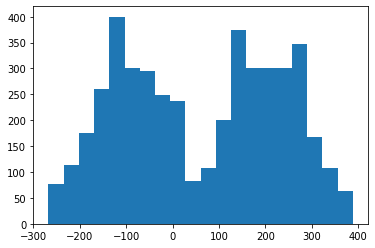

<Figure size 432x288 with 0 Axes>

In [18]:
print("RA", np.min(V_bound_ra), np.max(V_bound_ra))
#print("Dec", np.min(V_bound_dec), np.max(V_bound_dec))
plt.hist(V_bound_ra, bins=20)
plt.figure()
print(ecc)

False
nan
 x   y   z 
Myr Myr Myr
--- --- ---
nan nan nan


/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


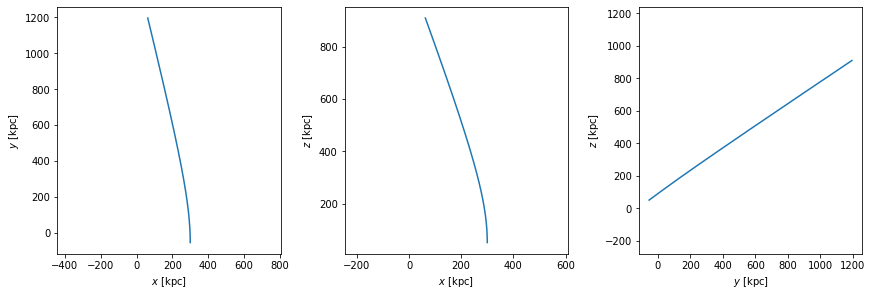

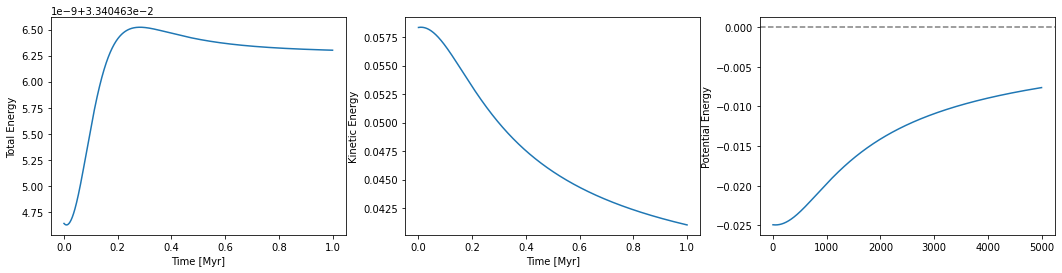

In [19]:

#checking if limiting velocities on higher end give good orbits (closed)
#checking if the lowest vel make sense

# RA +
vr = np.max(V_bound_ra)
vel = get_3D_cart_vel(v_sat, vr,PA)
w0 = gd.PhaseSpacePosition(pos=[x,y,z]*u.kpc,vel=vel*u.km/u.s)
orbit = potential.integrate_orbit(w0, dt=-1, n_steps=N)

orbit.plot()
U1 = orbit.energy(potential)

plt.figure(figsize=(18,4))
T = np.linspace(0,1, N+1)
plt.subplot(131)
plt.plot(T, U1)
plt.xlabel("Time [Myr]")
plt.ylabel("Total Energy")
plt.subplot(132)
plt.plot(T, orbit.kinetic_energy())
plt.xlabel("Time [Myr]")
plt.ylabel("Kinetic Energy")
plt.subplot(133)
plt.plot(orbit.potential_energy())
plt.ylabel("Potential Energy")
plt.axhline(0, ls='--', c='gray')
print(all(U1<0))
print(orbit.eccentricity())
print(orbit.estimate_period())

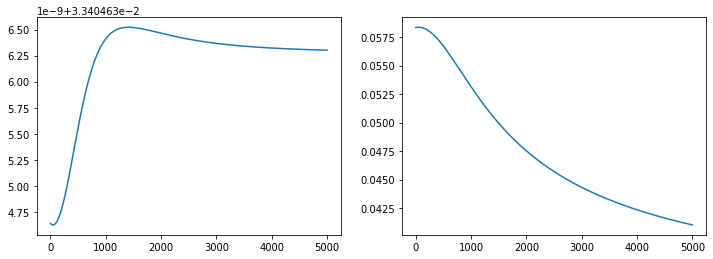

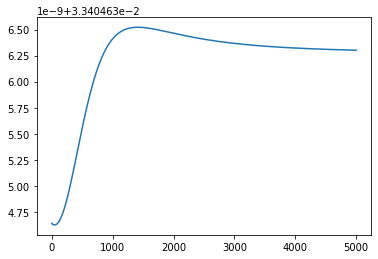

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(orbit.energy(potential))
plt.subplot(122)
plt.plot(orbit.kinetic_energy())
plt.figure()
plt.plot(orbit.energy())

-5.05050505050508
-5.05050505050508


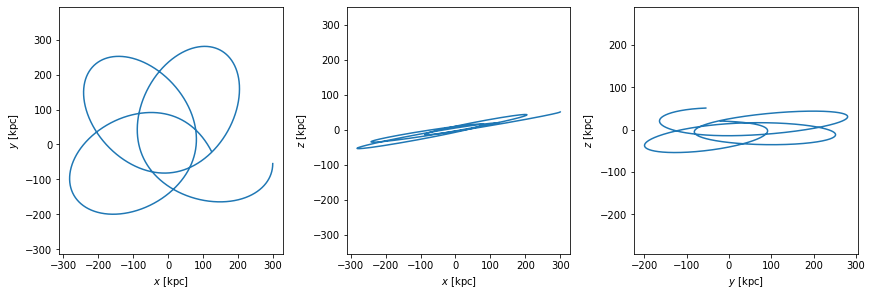

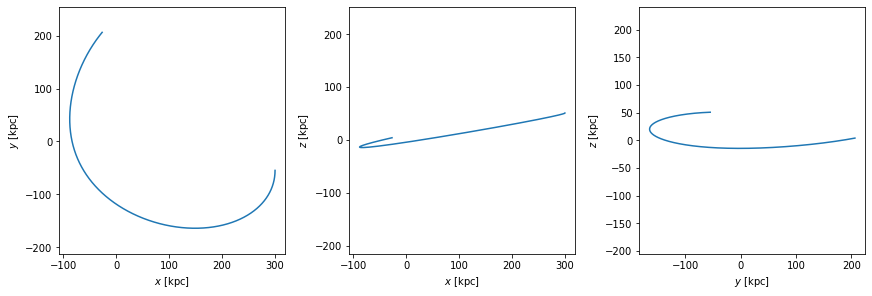

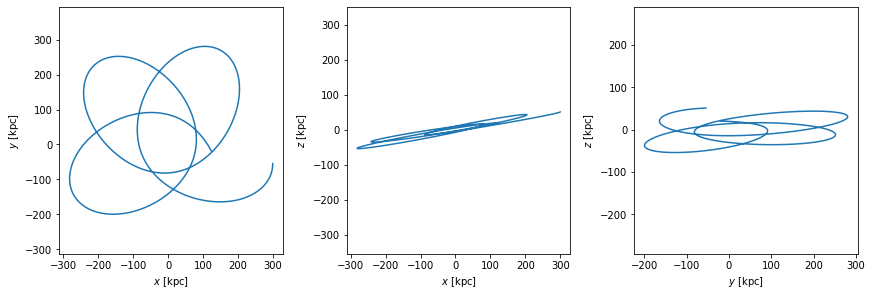

In [21]:
# check the limiting velocities on low edge
V_bound_ra = np.array(V_bound_ra)
a = np.where(V_bound_ra < 0)
print(np.max(V_bound_ra[a]))
vr = np.max(V_bound_ra[a])

#checking if the lowest vel make sense
vel_1 = get_3D_cart_vel(v_sat, vr,PA)
w0_1 = gd.PhaseSpacePosition(pos=[x,y,z]*u.kpc,vel=vel_1*u.km/u.s)
orbit1 = potential.integrate_orbit(w0_1, dt=-1*u.Myr, n_steps=N)
orbit1.plot()

#positive lowest
a = np.where(V_bound_ra < 0)
print(np.max(V_bound_ra[a]))
vr = np.max(V_bound_ra[a])

vel_1 = get_3D_cart_vel(v_sat, vr,PA)
w0_1 = gd.PhaseSpacePosition(pos=[x,y,z]*u.kpc,vel=vel_1*u.km/u.s)
orbit1 = potential.integrate_orbit(w0_1, dt=-5*u.Myr, n_steps=N)
orbit1.plot()

[[12.50995983 12.4508857  12.53679963 12.44902328 12.50785626 12.49507773
  12.46505756 12.54083953 12.45241697 12.52107757 12.48865678 12.47260535
  12.53559134 12.45037815 12.52946079 12.4797186  12.48926134 12.53745186
  12.45551173 12.54083728 12.4765915  12.50945707 12.54111875 12.46552695]] kpc False


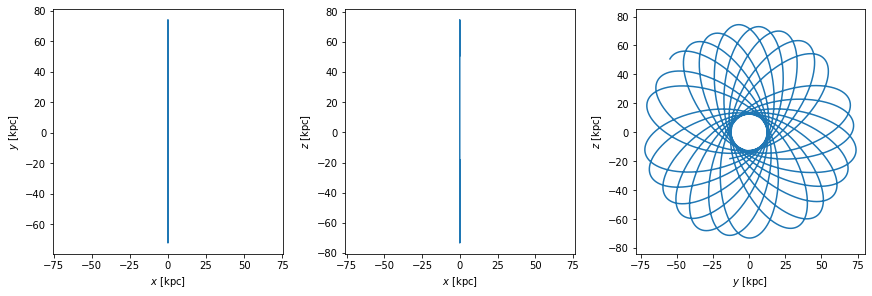

In [22]:
vr = np.sqrt(3) * v_t
x = 0
vel_1 = get_3D_cart_vel(v_sat, vr,PA)
w0_1 = gd.PhaseSpacePosition(pos=[x,y,z]*u.kpc,vel=vel_1*u.km/u.s)
orbit = potential.integrate_orbit(w0_1, dt=-5*u.Myr, n_steps=N)
#U1 = orbit1.energy(pot)
orbit.plot()
p = orbit.pericenter(func=None)
q = (p > 20*u.kpc).all()
print(p, q)

In [23]:
#             # within 5 Myr how many times orbit crossed near QSO (right now arbitrary 0.2 deg -> 72 kpc)
#             s1 = c_icrs.separation(cooQ1)
#             t1 = np.size(np.where(s1 < 0.2*u.deg)) * time_step

#             s2 = c_icrs.separation(cooQ2)
#             t2 = np.size(np.where(s2 < 0.2*u.deg)) * time_step

#             s3 = c_icrs.separation(cooQ3)
#             t3 = np.size(np.where(s3 < 0.2*u.deg)) * time_step
#             #orbit1.plot(["y","z"])
#     #         coq1r, coq2r, coq3r = 0,0,0
    #         for i in range(np.size(c_icrs.ra)):
    #             d1 = c_icrs[i].separation(cooQ1)
    #             d2 = c_icrs[i].separation(cooQ2)
    #             d3 = c_icrs[i].separation(cooQ3)
    #             if d1 < 0.2*u.deg:
    #                 coq1r+=1
    #             if d2 < 0.2*u.deg :
    #                 coq2r+=1
    #             if d3 < 0.2*u.deg:
    #                 coq3r+=1

#         if all(U2 < 0) and per1.value > 20.:
#             c = coord.SkyCoord(orbit2.pos, representation_type='cartesian', frame=host_centric)
#             cg=c.transform_to(host_centric)
#             c_icrs=cg.transform_to(coord.ICRS)

#             # within 5 Myr how many times orbit crossed near QSO (right now arbitrary 0.2 deg -> 72 kpc)
#             s1=c_icrs.separation(cooQ1)
#             t1_2=np.size(np.where(s1 < 0.2*u.deg)) * time_step

#             s2=c_icrs.separation(cooQ2)
#             t2_2=np.size(np.where(s2 < 0.2*u.deg)) * time_step

#             s3=c_icrs.separation(cooQ3)
#             t3_2=np.size(np.where(s3 < 0.2*u.deg)) * time_step

            #coq1d, coq2d, coq3d = 0,0,0

    #         for i in range(np.size(c_icrs.ra)):
    #             d1 = c_icrs[i].separation(cooQ1)
    #             d2 = c_icrs[i].separation(cooQ2)
    #             d3 = c_icrs[i].separation(cooQ3)
    #             if d1 < 0.2*u.deg:
    #                 coq1d+=1
    #             if d2 < 0.2*u.deg :
    #                 coq2d+=1
    #             if d3 < 0.2*u.deg:
    #                 coq3d+=1

            #orbit2.plot(["y","z"])
        #print("x", x, "RV", vr,"Vt RA", "Q1", t1, "Q2", t2, "Q3", t3, "Vt Dec", "Q1", t1_2.value, "Q2", t2_2.value, "Q3", t3_2.value )
       # l = np.array([x,vr,v_sat,t1.value,t2.value,t3.value,v_sat,t1_2.value, t2_2.value, t3_2.value])
       # L.add_row(l)
#np.savetxt("orbit-cross.dat", L)

## Choose the orbit


True
0.593731545236483
-1265.6666666666667 Myr
20.586569730012286 kpc


/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/gala/dynamics/orbit.py:652: GalaDeprecationWarning: Passing radial=True in estimate_period() is now deprecated. This method now returns period estimates for all orbital components. If you want to get just the radial period, use orbits.physicsspherical.estimate_period() instead.
  warnings.warn(


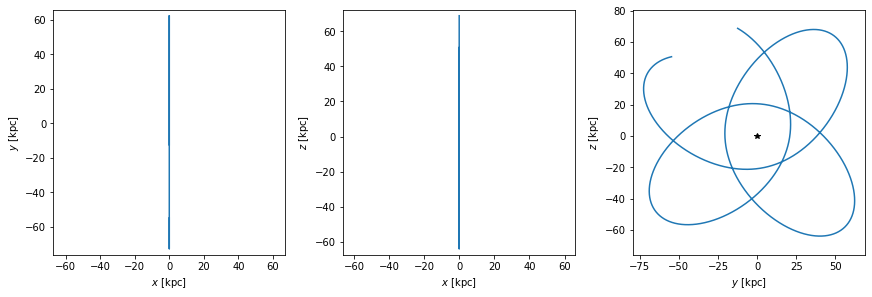

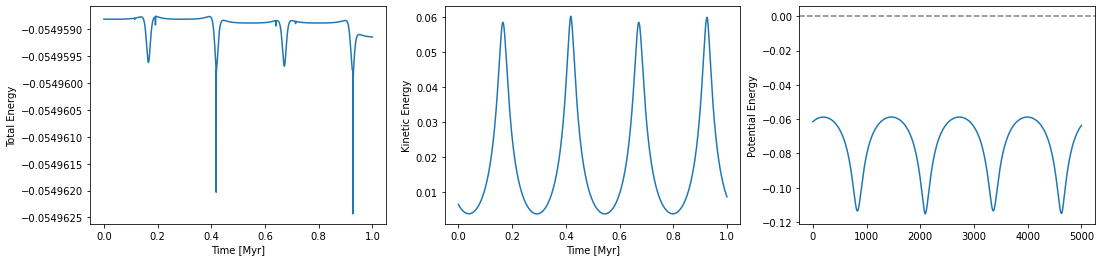

In [24]:
# RA +
N= int(5./0.001)
vr = np.max(-50)
vel = get_3D_cart_vel(v_sat, vr,PA)
w0 = gd.PhaseSpacePosition(pos=[x,y,z]*u.kpc,vel=vel*u.km/u.s)
orbit = potential.integrate_orbit(w0, dt=-1 * u.Myr, n_steps=N)

orbit.plot()
U1 = orbit.energy(potential)
plt.plot(0,0, "k*")

plt.figure(figsize=(18,4))
T = np.linspace(0,1, N+1)

plt.subplot(131)
plt.plot(T, U1)
plt.xlabel("Time [Myr]")
plt.ylabel("Total Energy")
plt.subplot(132)
plt.plot(T, orbit.kinetic_energy())
plt.xlabel("Time [Myr]")
plt.ylabel("Kinetic Energy")
plt.subplot(133)
plt.plot(orbit.potential_energy())
plt.ylabel("Potential Energy")
plt.axhline(0, ls='--', c='gray')
print(all(U1<0))
print(orbit.eccentricity())
print(orbit.estimate_period(y))
print(orbit.pericenter())
torb = orbit.estimate_period(y)

In [25]:
# t0 is the first pericenter time
peri = orbit.pericenter(func=None, return_times=True)
t0 = peri[1][0] #first peri
print(torb)
t1 = t0+torb

print(t0, t1) 


-1265.6666666666667 Myr
-4625.008809866461 Myr -5890.675476533128 Myr


## Gas

### Assumption all gas lost on one orbit (one round)

In [26]:
# we assume that gas was los steadily through the wole time, so the total gas along the orbit is now == Mgas0

In [27]:
# gas mass
m_gas_sf  # solar masses

# dwarf looses al that gas during one orbit, evenly distribution over the orbit
mdot = m_gas_sf*(u.Msun) / torb

print(np.log10(mdot.value))

nan


<ipython-input-27-72eb8134562c>:7: RuntimeWarning: invalid value encountered in log10
  print(np.log10(mdot.value))


<Figure size 432x288 with 0 Axes>

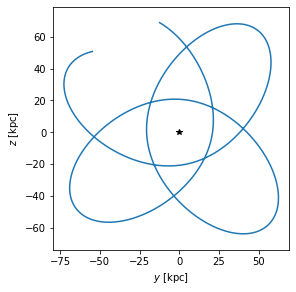

In [28]:
plt.figure()
orbit.plot(['y','z'])
plt.plot(0,0, '*k')


In [29]:
# start time T0 , start of ht eintegraiton
T0 = (-1 * N)*u.Myr
print(T0,t0)
print(int(abs((T0 - t0)/u.Myr)))
a = int(abs((T0 - t0)/u.Myr))
b = int(abs((T0 - (t0+2*torb))/u.Myr))

-5000.0 Myr -4625.008809866461 Myr
374


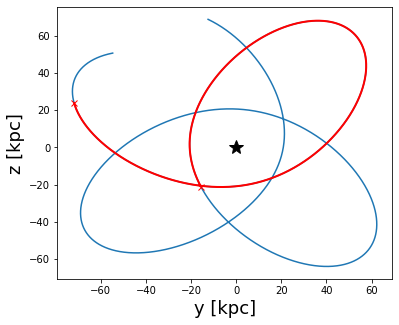

In [30]:
plt.figure(figsize=(6,5))
ax=plt.subplot(111)
plt.plot(orbit.pos.y, orbit.pos.z)
plt.plot(orbit.pos.y[a], orbit.pos.z[a],'rx')
plt.plot(orbit.pos.y[b], orbit.pos.z[b],'rx')
plt.plot(orbit.pos.y[a:b], orbit.pos.z[a:b], 'r', lw=2)
plt.plot(0,0, '*k', ms=15)

c=plt.Circle((orbit.pos.y[a].value, orbit.pos.z[a].value), 5e-3)
ax.add_patch(c)
plt.xlabel("y [kpc]", fontsize=18)
plt.ylabel("z [kpc]", fontsize=18)
# 2D densityfor simplicity
# I want +/- 10 kpc from the orbit to have gas
K = np.size(orbit.pos.x[a:b])

# for k in range(0,K,100):
#     co = plt.Circle((orbit.pos.y[a:b][k].value,orbit.pos.z[a:b][k].value),10, fc='none', ec='red')
#     ax.add_patch(co)

In [31]:
#density array 1 kpc resolution
K = np.size(orbit.data.y[a:b].value)
density = np.zeros((K,K))

# move all coordinates +100 
X = np.array(orbit.data.y[a:b].value+100, dtype='int')
Y = np.array(orbit.data.z[a:b].value+100, dtype='int') 


# the Particles

In [164]:
pot=potential

In [142]:
x = 0
y = dz.value
z = dy.value

In [143]:
P = -torb.value
print(P)

1265.6666666666667


In [144]:
# RA +
N = int(5./0.001)

vel = get_3D_cart_vel(v_sat, vr,PA)
w0 = gd.PhaseSpacePosition(pos=[x,y,z]*u.kpc,vel=vel*u.km/u.s)
orbit = potential.integrate_orbit(w0, dt=-1 * u.Myr, n_steps=N)
orbit2 = potential.integrate_orbit(w0, dt=1 * u.Myr, n_steps=P)

In [145]:
# new initial conditions starting in peri
w0_peri = gd.PhaseSpacePosition(pos=orbit.pos[b],vel=orbit.vel[b])

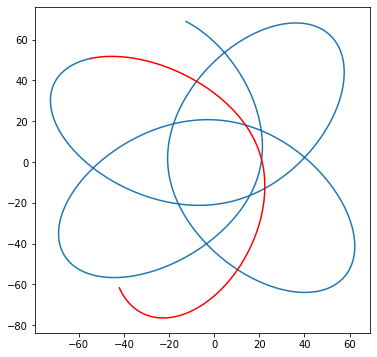

In [146]:
plt.figure(figsize=(6,6))
plt.plot(orbit.pos.y, orbit.pos.z)
plt.plot(orbit2.pos.y, orbit2.pos.z, c='r')

In [147]:
norbits = 2500
new_pos = np.random.normal(w0_peri.pos.xyz.to(u.pc).value, 2000.,  # the spread - dwarf effective radius here 2 kpc
                           size=(norbits,3)).T * u.pc
new_vel = np.random.normal(w0_peri.vel.d_xyz.to(u.km/u.s).value, 20., # velocity scale - dispersion around the orbital velocity, max rotational
                           size=(norbits,3)).T * u.km/u.s
new_ics = gd.PhaseSpacePosition(pos=new_pos, vel=new_vel)
orbits = potential.integrate_orbit(new_ics, dt=1 * u.Myr, n_steps=N)

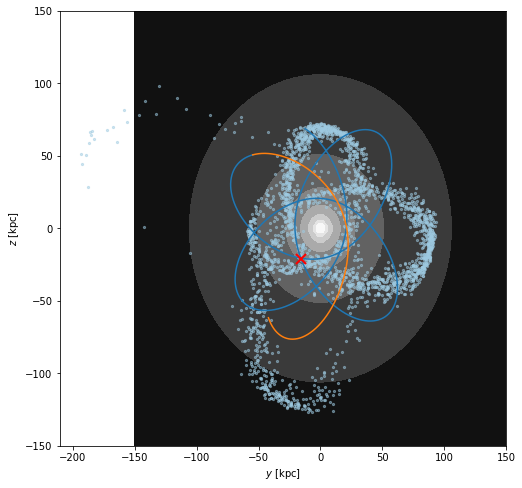

In [148]:
# plot the orbits (final positions) over the isopotential contours
grid = np.linspace(-150,150,64)
fig,ax = plt.subplots(1, 1, figsize=(8,8))
fig = pot.plot_contours(grid=(grid,grid,0), cmap='Greys', ax=ax)
fig = orbits[-1].plot(['y', 'z'], color='#9ecae1', s=20., alpha=0.5,
                       axes=[ax], auto_aspect=False) 
# for i in range(0, 3*P, 100):
#     fig = orbits[i].plot(['y', 'z'], color='#9ecae1', s=20., alpha=0.5,
#                       axes=[ax], auto_aspect=False) 
ax.plot(orbit.pos.y, orbit.pos.z)
ax.plot(orbit2.pos.y, orbit2.pos.z)
ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=10, markeredgewidth=2)
#ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=20, markeredgewidth=2)


In [149]:
# translate the stream to the ICRS (on the sky)

In [150]:
# represent satellite in a new frame
sat = SkyCoord(149.6921195816266*u.deg, 32.51841252708709*u.deg,frame='icrs', representation_type='spherical')
satd = sat.realize_frame(SphericalRepresentation(lon=sat.data.lon, lat=sat.data.lat,distance=dist))

In [151]:
#transformation of the orbit 
c = coord.SkyCoord(orbit.pos, representation_type='cartesian', frame=host_centric)  # SkyCoords
cg = c.transform_to(host_centric)  # translate to the host-centric coords
c_icrs=cg.transform_to(coord.ICRS)  # translate to ICRS

In [152]:
# transformaiton of the stream

c_str = coord.SkyCoord(orbits[-1].pos, representation_type='cartesian', frame=host_centric)  # SkyCoords
cg_str = c_str.transform_to(host_centric)  # translate to the host-centric coords
c_icrs_str=cg_str.transform_to(coord.ICRS)  # translate to ICRS
 

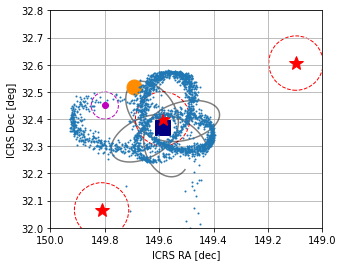

In [153]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, aspect='equal')
ax.set_xlim(150., 149)
ax.set_ylim(32., 32.8)
ax.set_xlabel("ICRS RA [dec]")
ax.set_ylabel("ICRS Dec [deg]")
ax.grid()

ax.plot(c_icrs.ra, c_icrs.dec, 'k', alpha=.5)
ax.plot(host.ra, host.dec, 's',ms = 15, color='navy')
ax.plot(sat.ra, sat.dec, 'o',ms=15, c='darkorange')
ax.plot(cooQ1.ra, cooQ1.dec, '*', ms=15, c='red')
ax.plot(cooQ2.ra, cooQ2.dec, '*', ms=15, c='red')
ax.plot(cooQ3.ra, cooQ3.dec, '*', ms=15, c='red')
circle1 = plt.Circle((cooQ1.ra.value, cooQ1.dec.value), 0.1, facecolor='none', edgecolor='red', ls='--')
circle2 = plt.Circle((cooQ2.ra.value, cooQ2.dec.value), 0.1, facecolor='none', edgecolor='red', ls='--')
circle3 = plt.Circle((cooQ3.ra.value, cooQ3.dec.value), 0.1, facecolor='none', edgecolor='red', ls='--')

ax.plot(c_icrs_str.ra, c_icrs_str.dec, 'o', ms=1.)

ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.plot(149.8, 32.45, 'om')
circle = plt.Circle((149.8, 32.45), 0.05, facecolor='none', edgecolor='m', ls='--')
ax.add_patch(circle)


In [154]:
# assume that all particless are equal mmass and all gas was removed instanteniusly
# for the SF gas dwarf content
m_part = m_gas_sf / norbits
print(np.log10(m_part))

4.342059991327963


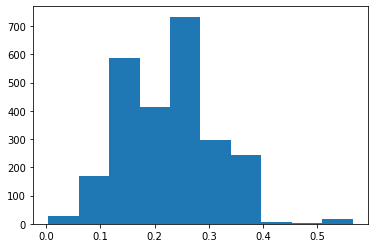

In [155]:
# find particles within the selected "sightline" 
sight = SkyCoord(149.8*u.deg, 32.45*u.deg, frame='icrs')
final_orbit = c_icrs_str

# calculate the separation between the sightline and the particles
sep = sight.separation(final_orbit)
plt.hist(sep.deg)

# find  particles within 0.05 deg
a = np.where(sep <= 0.05 * u.deg)


In [156]:
# how much mass within the sightline
mass = np.size(sep[a]) *  m_part *u.Msun

#assume the path  == galaxy diameter and calculate the column density 
rs = 2 * u.kpc

#density
dens = mass / (4./3. * np.pi * rs**3)
dens.to(u.kg/u.cm**3)

<Quantity 7.54717797e-31 kg / cm3>

## NFW + stellar potential of the satellite of a satellite 

In [157]:
## Find NFW profile, using parameters and scaling rlation from Tollerud 2011

In [158]:
L12 = Lsat / 2.  # L_1/2 = L /2 
#similarly we can calculate the r1/2 but I don't have Re so I will use the scaling relations
r12 =  0.1 # kpc
M12 = m_star # virtually same as the msat
print(f"L1/2 {np.log10(L12):.2f} r1/2 {r12:.2f} kpc M1/2 {np.log10(M12):.2f} Msol")

L1/2 6.86 r1/2 0.10 kpc M1/2 7.17 Msol


In [159]:
# in this regime Re will be 
Re = 3./4. * r12
print(f"Re {Re:.2f} kpc")

Re 0.08 kpc


In [160]:
# from the relations between L12 and M12DM
Mvir_DM = 10**10
h=0.7

In [161]:
# concentration

c = 12. * (Mvir_DM / 10**12 / (1/h))** (-0.075)
print(c)

17.41000488790022


In [162]:

sat_pot = gp.NFWPotential.from_M200_c(10**8 *u.Msun,c, units=galactic)

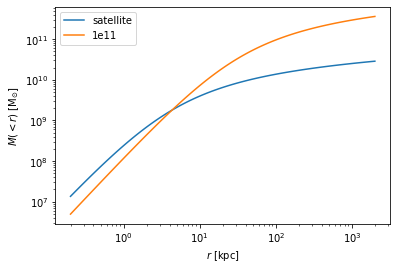

In [165]:
sat_pot = gp.NFWPotential.from_M200_c(Mvir_DM *u.Msun,c, units=galactic)
pot_comp = gp.NFWPotential(m=1E11*u.Msun, r_s=20.*u.kpc, units=galactic)

pos = np.zeros((3,100)) * u.kpc
pos[0] = np.logspace(np.log10(20./100.), np.log10(20*100.), pos.shape[1]) * u.kpc
m_profile = sat_pot.mass_enclosed(pos)
m_profile2 = pot_comp.mass_enclosed(pos)
plt.loglog(pos[0], m_profile, marker='', label='satellite')
plt.loglog(pos[0], m_profile2, marker='', label='1e11')
plt.xlabel("$r$ [{}]".format(pos.unit.to_string(format='latex'))) 
plt.ylabel("$M(<r)$ [{}]".format(m_profile.unit.to_string(format='latex'))) 
plt.legend()

In [166]:
## Folowing only forces from Adrian's code first withouth the dwarf self interqaction


In [167]:
def F_nodrag_nosat(t, w):
    # position units are in kpc
    # velocity units here are in kpc/Myr
    x, y, z, vx, vy, vz = w
    
    q = np.stack((x, y, z), axis=1)
    p = np.stack((vx, vy, vz), axis=1)
    
    # compute acceleration from milky way:
    _t = np.array([0.])
    acc = -pot._gradient(q, _t).T
    
    acc[:, 0] = acc[:, 0] 
    
    return np.vstack((p.T, acc))

In [168]:
# Compute the orbit in a Milky Way model without drag by integrating backwards in time

#starting position ofhte satelite and particles - peri

w0_peri  #satellite
print(w0_peri)

#starting position of gas particles in peri
norbits = 2500
new_pos = np.random.normal(w0_peri.pos.xyz.to(u.kpc).value, 2*u.kpc,  # the spread - dwarf effective radius here 2 kpc
                           size=(norbits,3)).T * u.kpc
new_vel = np.random.normal(w0_peri.vel.d_xyz.to(u.kpc/u.Myr).value, (20. *u.km/u.s).to(u.kpc/u.Myr), # velocity scale - dispersion around the orbital velocity, max rotational
                           size=(norbits,3)).T * u.kpc/u.Myr
new_ics = gd.PhaseSpacePosition(pos=new_pos, vel=new_vel)
print(new_ics)

pos=(0., -15.59636496, -21.1071002) kpc
vel=(0., -0.12478253, 0.28383429) kpc / Myr
pos=[(-0.27811278, -14.58968041, -21.46877008),
 (-1.14186178, -13.93861233, -21.39144837),
 (-0.3032993 , -10.41493348, -23.44609955), ...,
 (-3.86027376, -13.66239199, -22.93457492),
 ( 1.50909466, -16.29468251, -19.57915499),
 (-1.24571931, -17.59354052, -22.34172666)] kpc
vel=[( 0.01170396, -0.13180624, 0.31590728),
 (-0.00641669, -0.10677971, 0.25549501),
 ( 0.02275746, -0.11562835, 0.31500657), ...,
 (-0.03627713, -0.1476884 , 0.27971955),
 (-0.00338377, -0.11819904, 0.2872    ),
 ( 0.02229108, -0.09424895, 0.30704083)] kpc / Myr


In [169]:
# compute the orbit  forwards
integrator = gi.DOPRI853Integrator(F_nodrag_nosat, func_units=galactic)
orbits_nodrag_nosat = integrator.run(gd.combine((new_ics, w0_peri)), 
                               dt=1, t1=0, t2=2*P) #dt step in Myr, from 0 to 2 orbits


In [170]:
orbit_nodrag_nosat = orbits_nodrag_nosat[:, :-1]
orbit_sat_nosat = orbits_nodrag_nosat[:, -1]

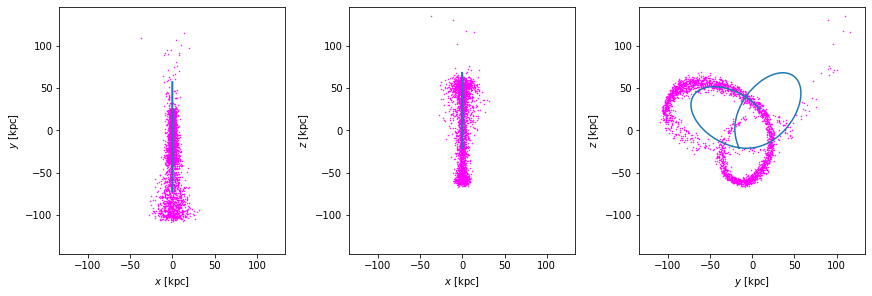

In [171]:
fig = orbit_nodrag_nosat[-1].plot(s=1, c='magenta')
_ = orbit_sat_nosat.plot(axes=fig.axes)
for ax in fig.axes:
    ax.set_xlim(-200, 200)
    ax.set_ylim(-150, 150)
    
# this is just a biunch of points propagatingin MW potential. 

Text(0.5, 1.0, 'No drag and no satellite gravity')

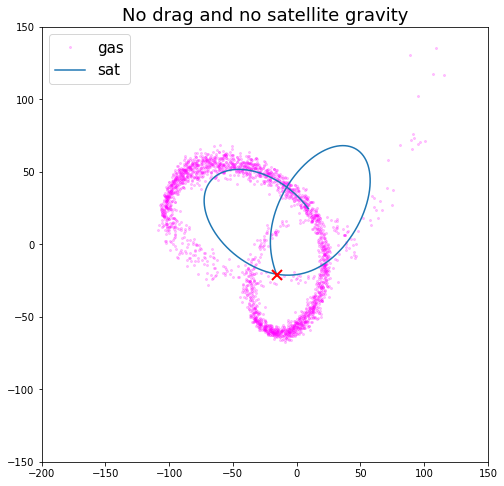

In [172]:
fig,ax = plt.subplots(1, 1, figsize=(8,8))
#fig = pot.plot_contours(grid=(grid,grid,0), cmap='Greys', ax=ax)
# fig = orbits_nodrag_nosat[-1].plot(['z', 'y'], color='magenta', s=20., alpha=0.2,
#                        axes=[ax], auto_aspect=False) 
plt.plot(orbits_nodrag_nosat[-1].pos.y, orbits_nodrag_nosat[-1].pos.z, 'o', color='magenta', ms=2., alpha=0.2,label='gas')
ax.plot(orbit_sat_nosat.pos.y, orbit_sat_nosat.pos.z, label='sat')
# ax.plot(orbit2.pos.y, orbit2.pos.z)
ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=10, markeredgewidth=2)
#ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=20, markeredgewidth=2)
ax.set(xlim=[-200,150], ylim=[-150,150])
plt.legend(fontsize=15)
plt.title("No drag and no satellite gravity", fontsize=18)

In [173]:
## Adding satellite gravity still no drag/RAM pressure

In [221]:
def F_nodrag(t, w):
    # position units are in kpc
    # velocity units here are in kpc/Myr
    x, y, z, vx, vy, vz = w
    
    q = np.stack((x, y, z), axis=1)
    p = np.stack((vx, vy, vz), axis=1)
    
    # compute acceleration from milky way:
    _t = np.array([0.])
    acc = -pot._gradient(q, _t).T
    
    # Force from the satellite itself

    sat = pot_comp#sat_pot     # NFW halo
    #sat = gp.HernquistPotential(m=2e11*u.Msun, c=12.40*u.kpc, 
       #                         units=galactic, origin=q[1])
    sat_acc = sat.acceleration(q[0]).value[:, 0]

    acc[:, 0] = acc[:, 0] + sat_acc
    
    return np.vstack((p.T, acc))

In [222]:
#using the same initail conditions as previously
# compute the orbit  forwards
integrator = gi.DOPRI853Integrator(F_nodrag, func_units=galactic)
orbits_nodrag = integrator.run(gd.combine((new_ics, w0_peri)), 
                               dt=1, t1=0, t2=2*P) #dt step in Myr, from 0 to 2 orbits

In [223]:
orbit_nodrag = orbits_nodrag[:, :-1]
orbit_sat = orbits_nodrag[:, -1]

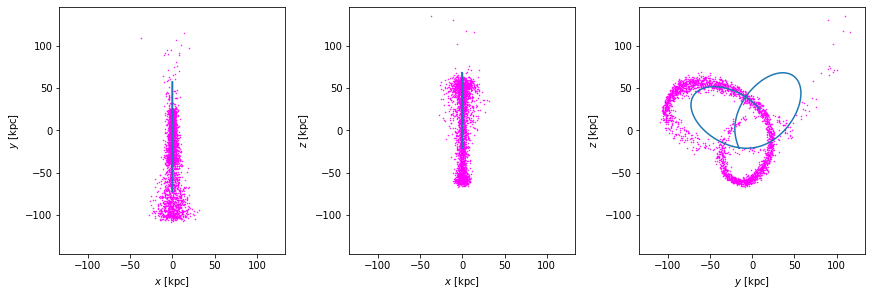

In [224]:
fig = orbit_nodrag[-1].plot(s=1, c='magenta')
_ = orbit_sat.plot(axes=fig.axes)
for ax in fig.axes:
    ax.set_xlim(-200, 200)
    ax.set_ylim(-150, 150)

Text(0.5, 1.0, 'No drag with satellite gravity')

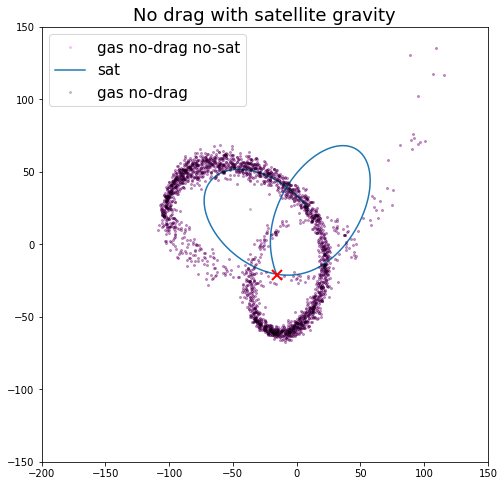

In [225]:
fig,ax = plt.subplots(1, 1, figsize=(8,8))
#fig = pot.plot_contours(grid=(grid,grid,0), cmap='Greys', ax=ax)
# fig = orbits_nodrag_nosat[-1].plot(['z', 'y'], color='magenta', s=20., alpha=0.2,
#                        axes=[ax], auto_aspect=False) 
plt.plot(orbits_nodrag_nosat[-1].pos.y, orbits_nodrag_nosat[-1].pos.z, 'o', color='magenta', ms=2., alpha=0.2,label='gas no-drag no-sat')
ax.plot(orbit_sat_nosat.pos.y, orbit_sat_nosat.pos.z, label='sat')
plt.plot(orbits_nodrag[-1].pos.y, orbits_nodrag_nosat[-1].pos.z, 'o', color='k', ms=2., alpha=0.2,label='gas no-drag')

# ax.plot(orbit2.pos.y, orbit2.pos.z)
ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=10, markeredgewidth=2)
#ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=20, markeredgewidth=2)
ax.set(xlim=[-200,150], ylim=[-150,150])
plt.legend(fontsize=15)
plt.title("No drag with satellite gravity", fontsize=18)

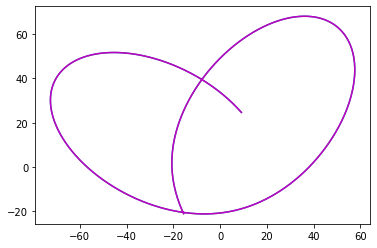

In [226]:
plt.plot(orbit_sat_nosat.pos.y, orbit_sat_nosat.pos.z, label='sat')
plt.plot(orbit_sat.pos.y, orbit_sat_nosat.pos.z, label='sat', c='m')


In [227]:
## adding RAM pressure
def F_drag(t, w, f_halo, f_disk, coupling_factor):
    # position units are in kpc
    # velocity units here are in kpc/Myr
    x, y, z, vx, vy, vz = w
    
    q = np.stack((x, y, z), axis=1)
    p = np.stack((vx, vy, vz), axis=1)
    
    r = np.linalg.norm(q, axis=1)[0] # galcen distance
    R = np.sqrt(x**2 + y**2)[0] # cylindrical radius
    
    # compute acceleration from milky way:
    _t = np.array([0.])
    acc = -pot._gradient(q, _t).T
    
    col_dens = 4.6 * 10 ** 20 * 1 / u.cm**2 ## Putman+2021 -> peak density from LEO T Adams & Oosterloo + 2018
    surf_dens = (col_dens * m_p).to_value(u.Msun / u.kpc ** 2)
    #surf_dens = 1e6 * surf_dense_func(t, -age.value, 0, surf_dens0)
    
    # compute drag acceleration    
    nn = f_halo * n_mw_halo(r) + f_disk * n_mw_disk(R, z[0])
    fac = (nn * _dens_fac) / surf_dens
    acc_drag = fac * np.sum(p[0:1]**2, axis=1) # rho / Sigma * v^2
    
    # in the direction opposite of motion
    acc_drag = -acc_drag * p[0:1] / np.sqrt(np.sum(p[0:1]**2, axis=1))
    acc_drag = acc_drag.T
    
    # ---
    
    # the Cartesian unit vector in the direction of galactic rotation 
    # at the current position of the orbit
    phi = np.arctan2(y[0], x[0])
    unit_vec = -np.array([-np.sin(phi), np.cos(phi), 0])
    
    # multiply by a gaussian so this only operates near the midplane
    acc_drag[:, 0] += coupling_factor * unit_vec * np.exp(-0.5 * z[0]**2 / sigz(R)**2)
    
    # ---
    # Force from the satellite itself
    sat = gp.HernquistPotential(m=m_star*u.Msun, c=5*u.kpc,  # using 2 kpc effective radius
                                units=galactic, origin=q[1])
    sat_acc = sat.acceleration(q[0]).value[:, 0]
    acc[:, 0] = acc[:, 0] + sat_acc
    acc[:, 0] += acc_drag[:, 0]
    
    return np.vstack((p.T, acc))

In [228]:
# RAM pressure stripping
## parameters of the MW halo to calculate the drag
# 1) gas surface density of the SATELLITE

# for the column density in the dwarf assume
from astropy.constants import m_p
col_dens = 4.6 * 10 ** 20 * 1 / u.cm**2 ## Putman+2021 -> peak density from LEO T Adams & Oosterloo + 2018
surf_dens = (col_dens * m_p).to_value(u.Msun / u.kpc ** 2)
(col_dens * m_p).to(u.Msun / u.pc**2)
# convert to survafe density
# for unit conversion
_dens_fac = m_p.to_value(u.Msun) * (1/u.cm**3).to_value(1/u.kpc**3)


In [229]:
#gas distribution functions for halo and disc (MW)

Rsun = 8.1 # * u.kpc

# A model for the number density of the halo:
def n_mw_halo(r):
    # From Miller & Bregman 2013
    n0 = 0.46 # / u.cm**3
    rc = 0.35 # * u.kpc
    beta = 0.71
    return n0 * (1 + (r/rc)**2) ** (-1.5 * beta)


# A model for the number density of the disk:
# - Note: it flares as a function of radius, so need a 
#   function to compute the scale height at a given R
def hz(R):
    h0 = 0.15 # * u.kpc
    R0 = 9.8 # * u.kpc
    hz = h0 * np.exp((R-Rsun) / R0)
    return hz

def sigz(R):
    return 0.85 * hz(R)
    
def n_mw_disk(R, z):
    # From Kaberla review
    # s = sigz(R)
    s = hz(R)
    
    n0 = 0.9 # / u.cm**3
    Rn = 3.15 # * u.kpc
    
    # note: I added the z dependence
    # return n0 * np.exp(-(R-Rsun)/Rn) * np.exp(-0.5 * z**2 / s**2)
    return n0 * np.exp(-(R-Rsun)/Rn) * np.exp(-np.abs(z) / s)

In [232]:
magic_factor_disk = 0.8
magic_factor_halo = 1.

In [233]:
# compute the orbit  forwards
integrator = gi.DOPRI853Integrator(F_drag, func_units=galactic,
                                   func_args=(magic_factor_halo, magic_factor_disk, 0))
orbits_drag = integrator.run(gd.combine((new_ics, w0_peri)), 
                               dt=1, t1=0, t2=2*P) #dt step in Myr, from 0 to 2 orbits


In [234]:
orbit_drag = orbits_drag[:, :-1]
orbit_sat_drag = orbits_drag[:, -1]

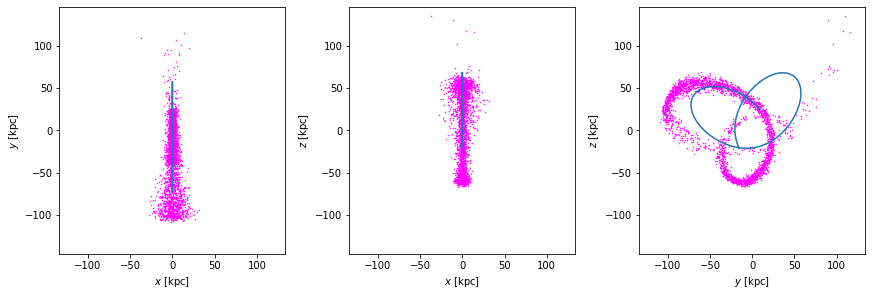

In [235]:
fig = orbit_drag[-1].plot(s=1, c='magenta')
_ = orbit_sat.plot(axes=fig.axes)
for ax in fig.axes:
    ax.set_xlim(-200, 200)
    ax.set_ylim(-150, 150)

Text(0.5, 1.0, 'RAM pressure + satellite gravity')

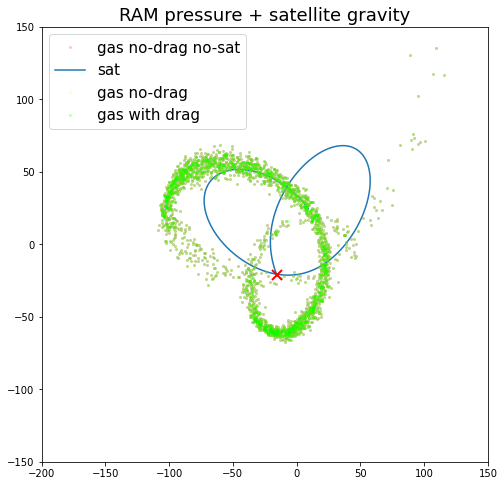

In [236]:
fig,ax = plt.subplots(1, 1, figsize=(8,8))
#fig = pot.plot_contours(grid=(grid,grid,0), cmap='Greys', ax=ax)
# fig = orbits_nodrag_nosat[-1].plot(['z', 'y'], color='magenta', s=20., alpha=0.2,
#                        axes=[ax], auto_aspect=False) 
plt.plot(orbit_nodrag_nosat[-1].pos.y, orbit_nodrag_nosat[-1].pos.z, 'o', color='magenta', ms=2., alpha=0.2,label='gas no-drag no-sat')
ax.plot(orbit_sat_nosat.pos.y, orbit_sat_nosat.pos.z, label='sat')
plt.plot(orbit_nodrag[-1].pos.y, orbit_nodrag[-1].pos.z, 'o', color='yellow', ms=2., alpha=0.2,label='gas no-drag')
plt.plot(orbit_drag[-1].pos.y, orbit_drag[-1].pos.z, 'o', color='lime', ms=2., alpha=0.2,label='gas with drag')

# ax.plot(orbit2.pos.y, orbit2.pos.z)
ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=10, markeredgewidth=2)
#ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=20, markeredgewidth=2)
ax.set(xlim=[-200,150], ylim=[-150,150])
plt.legend(fontsize=15)
plt.title("RAM pressure + satellite gravity", fontsize=18)